## Preparation

#### Problem left: mismatch in dimension.

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [ ]:
# device check(CFDLab)
device=torch.device('cuda:1') #先調1再調0
print(torch.cuda.is_available())
x=torch.randn(100).to(device) # Gives warning

In [ ]:
device=torch.device('cuda:0') # Fix warning
x=torch.randn(100).to(device) # No warning

In [3]:
# device check(my pc)
device=torch.device('cpu')
print(torch.cuda.is_available())
x=torch.randn(100).to(device) # No warning

False


## Parameters

In [13]:
batch=100 #batchsize
opt=1 # optimizer
tol=1e-2 # tolerance
ch=[1, 3, 3, 3, 3, 1] #model layout
pad=[0, 0, 0, 0, 0]
PATH= "ABS_UNS_CNN_TEST" # model name, saved as..

## Data

In [5]:
# Step 1. Prepare data-1/2
# DataLoader wraps a Dataset and provides minibatches, shuffling, multithreading, for you
data_in=np.loadtxt('./data/preserved/input_div_U_2_1s.dat')
x_in=torch.Tensor(data_in)
x_in=x_in.to(device)

In [6]:
x=x_in
print(x.size())

torch.Size([1000, 6400])


In [7]:
loader=DataLoader(TensorDataset(x, x), batch_size=batch)

## Model

In [8]:
# Convolutional neural network (two convolutional layers)
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(torch.nn.Module):
    def __init__(self, channel_1, channel_2, channel_3, channel_4, channel_5, kernel_dim):
        super(ConvNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, channel_1, kernel_dim, padding=pad[0])
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_dim, padding=pad[1])
        self.conv3 = nn.Conv2d(channel_2, channel_3, kernel_dim, padding=pad[2])
        self.conv4 = nn.Conv2d(channel_3, channel_4, kernel_dim, padding=pad[3])
        self.conv5 = nn.Conv2d(channel_4, channel_5, kernel_dim, padding=pad[4])
        # an affine operation: y = Wx + b
        lin_d=80-(pad[0]+pad[1]+pad[2]+pad[3]+pad[4])*2
        self.fc1 = nn.Linear(70*70*channel_5, 6400)  # 78*78 from image dimension
        #self.fc2 = nn.Linear(1000, 1000)
        #self.fc3 = nn.Linear(1000, 6400)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc1(x)
        return x

model = ConvNet(channel_1=ch[1], channel_2=ch[2], channel_3=ch[3], channel_4=ch[4], channel_5=1, kernel_dim=3).to(device)

## Training

In [9]:
if opt==0:
    optimizer=torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
elif opt==1:
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

In [10]:
loss_epoch=[]
loss_values = []
loss=1
epochs=0

print("Epochs    Loss")

while(loss>tol):
    epochs=epochs+1
    scheduler.step()
    
    for x_batch, y_batch in loader:
        # Forward pass
        x_batch= torch.nn.Sequential(torch.nn.Unflatten(1, (1,80,80)))(x_batch)
        y_pred=model(x_batch)        
        
        # Compute laplacian
        y_pred= torch.nn.Sequential(torch.nn.Unflatten(1, (80,80)))(y_pred)
        
        z=torch.concat([y_pred[:, :, :1], y_pred], axis=2)[:, :, :80]
        w=torch.concat([y_pred, y_pred[:, :, 79:]], axis=2)[:, :, 1:]
        m=torch.concat([y_pred[:, :1, :], y_pred], axis=1)[:, :80, :]
        n=torch.concat([y_pred, y_pred[:, 79:, :]], axis=1)[:, 1:, :]
        L_y_pred=(z+w+m+n-4*y_pred)*40 # h=1/80 /2h=>*40
        
        # fix dimension: [100, 1, 80, 80]-> [100, 80, 80]
        #with torch.no_grad():
        #    L_y_pred=L_y_pred*1
        #
        #L_y_pred_resized=L_y_pred.resize_(100, 1, 80, 80)
        
        loss=torch.nn.functional.mse_loss(L_y_pred, x_batch)
        
        # Backward pass
        loss.requires_grad_(True)
        loss.backward()
        
        # Update Weights
        optimizer.step()
        optimizer.zero_grad()
        #print("1 batch")
    
    loss_epoch.append(epochs)
    loss_values.append(loss.item())
    
    if epochs%1==0:
        print("Epochs: ", epochs, "; Loss: ", loss.item())
        
    loss=loss.item()

print(epochs, "    ", loss.item())

#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')

Epochs    Loss


/home/enchou/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/tmp/ipykernel_68800/671386213.py:32: UserWarning: Using a target size (torch.Size([100, 1, 80, 80])) that is different to the input size (torch.Size([100, 80, 80])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss=torch.nn.functional.mse_loss(L_y_pred, x_batch)


Epochs:  1 ; Loss:  0.27044370770454407
Epochs:  2 ; Loss:  0.16890862584114075
Epochs:  3 ; Loss:  0.09374116361141205
Epochs:  4 ; Loss:  0.06864944845438004
Epochs:  5 ; Loss:  0.05629420280456543
Epochs:  6 ; Loss:  0.050163209438323975
Epochs:  7 ; Loss:  0.04619150608778
Epochs:  8 ; Loss:  0.04332374036312103
Epochs:  9 ; Loss:  0.0409722626209259
Epochs:  10 ; Loss:  0.03895530477166176
Epochs:  11 ; Loss:  0.03716942295432091
Epochs:  12 ; Loss:  0.035562898963689804
Epochs:  13 ; Loss:  0.034106913954019547
Epochs:  14 ; Loss:  0.03278033435344696
Epochs:  15 ; Loss:  0.03156639635562897
Epochs:  16 ; Loss:  0.030451903119683266
Epochs:  17 ; Loss:  0.029425952583551407
Epochs:  18 ; Loss:  0.028478499501943588
Epochs:  19 ; Loss:  0.027601173147559166
Epochs:  20 ; Loss:  0.026786722242832184
Epochs:  21 ; Loss:  0.026028644293546677
Epochs:  22 ; Loss:  0.02532127872109413
Epochs:  23 ; Loss:  0.024659661576151848
Epochs:  24 ; Loss:  0.024039477109909058
Epochs:  25 ; Loss

AttributeError: 'float' object has no attribute 'item'

## Result

In [11]:
# Append name with time
from datetime import datetime
ct=datetime.now()
ctime=str(ct.year)+str(ct.month)+str(ct.day)+"_"+str(ct.hour)+str(ct.minute)+str(ct.second)
PATH=PATH+"_"+ctime+".pth"

FileNotFoundError: [Errno 2] No such file or directory: './result/./result/ABS_UNS_CNN_TEST_202321_141144.pth.png'

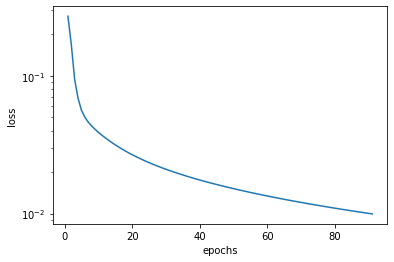

In [12]:
#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.semilogy()
plt.savefig("./result/"+PATH+'.png')

## Export

In [15]:
traced_net=torch.jit.trace(model, (torch.randn(1, 1, 80,80)).to(device))
traced_net.to(torch.float64)
torch.jit.save(traced_net, PATH)

In [ ]:
# Save information
with open("./result/"+PATH+'.txt', 'w') as f:
        f.write('# Model info\n')
        f.write('Model: '+ PATH+'\n')
        f.write('ID: '+ ctime +'\n')
        f.write('Data format: '+ 'Absolute' +'\n')
        f.write('Learning method: Unsupervised'+'\n')
        f.write('Model: CNN'+'\n')
        f.write('residual: '+str(tol)+'\n')
        f.write('batch_size: '+str(batch)+'\n')
        f.write('epochs: '+str(epochs)+'\n')